In [1]:
import pandas as pd
import numpy as np
import re
import json
import numpy as np
import timeit 
from datetime import datetime

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# Cufflinks wrapper on plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

# Set global theme

import plotly.figure_factory as ff

import plotly.graph_objects as go
import plotly.express as px

In [4]:
import plotly.express as px
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
import matplotlib.pyplot as plt
import geojsoncontour

from scipy.interpolate import griddata
from numpy import linspace

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
#Selecting a central city point to center all graphs around - Swietokrzyska Subway 
center_coors=52.235176, 21.008393

In [7]:
#df=pd.read_excel("RE_models_input.xlsx")
df=pd.read_excel("RE__models_input_enriched.xlsx")


In [8]:
df.head()

Id   Area   Price  latitude  longitude  build_year  \
0  60534950  80.10  760469  52.22124  20.956340        2021   
1  60534789  52.27  585204  52.22124  20.956340        2021   
2  60534636  64.63  672476  52.22124  20.956340        2021   
3  60441425  46.86  559000  52.22246  20.957040        2020   
4  60225257  57.40  779000  52.22623  20.956751        2019   

   building_floors_num rooms_num      City subdistrict  ...  \
0                    8         4  warszawa        Wola  ...   
1                    8         2  warszawa        Wola  ...   
2                    8         3  warszawa        Wola  ...   
3                   14         3  warszawa        Wola  ...   
4                   11         3  warszawa        Wola  ...   

  distance_return_transit_5PM time_return_transit_5PM  \
0                       4.763               24.933333   
1                       4.763               24.933333   
2                       4.763               24.933333   
3                       4.763               24.933333   
4                       4.763               24.933333   

  distance_return_driving_5PM time_return_driving_5PM price_decrease_from_20k  \
0                       4.632               12.383333              9079.66443   
1                       4.632               12.383333              9079.66443   
2                       4.632               12.383333              9079.66443   
3                       4.632               12.383333              9079.66443   
4                       4.632               12.383333              9079.66443   

  price_decrease_per_10min restaurant_price_level restaurant_mean_rating  \
0              3622.206554                    2.0                   3.51   
1              3622.206554                    2.0                   3.51   
2              3622.206554                    2.0                   3.51   
3              3622.206554                    2.0                   3.51   
4              3622.206554                    2.0                   3.51   

   restaurant_mean_popularity  restaurant_count  
0                       119.9                10  
1                       119.9                10  
2                       119.9                10  
3                       119.9                10  
4                       119.9                10  

[5 rows x 70 columns]

In [9]:
df['rooms_num']=np.where(df['rooms_num']=="more",10,df['rooms_num'])

In [10]:
df.drop(columns=['floor_no',"City","district_old",'price_decrease_from_20k','price_decrease_per_10min'],inplace=True)

In [11]:
df.columns

Index(['Id', 'Area', 'Price', 'latitude', 'longitude', 'build_year',
       'building_floors_num', 'rooms_num', 'subdistrict', 'market',
       'Building_material', 'Building_ownership', 'Building_type',
       'Construction_status', 'Heating', 'Windows_type',
       'Equipment_types_dishwasher', 'Equipment_types_fridge',
       'Equipment_types_furniture', 'Equipment_types_oven',
       'Equipment_types_stove', 'Equipment_types_tv',
       'Equipment_types_washing_machine', 'Extras_types_air_conditioning',
       'Extras_types_attic', 'Extras_types_balcony', 'Extras_types_basement',
       'Extras_types_garage', 'Extras_types_garden', 'Extras_types_lift',
       'Extras_types_separate_kitchen', 'Extras_types_terrace',
       'Extras_types_two_storey', 'Extras_types_usable_room',
       'Media_types_cable-television', 'Media_types_electricity',
       'Media_types_internet', 'Media_types_phone', 'Media_types_sewage',
       'Media_types_water', 'Security_types_alarm',
       'Security_

In [12]:
df["distance_driving"]=(df.distance_driving_8AM+df.distance_return_driving_5PM)/2
df["distance_transit"]=(df.distance_transit_8AM+df.distance_return_transit_5PM)/2
df["time_driving"]=(df.time_driving_8AM+df.time_return_driving_5PM)/2
df["time_transit"]=(df.time_return_transit_5PM+df.time_transit_8AM)/2

In [13]:
df.drop(columns=['distance_transit_8AM', 'time_transit_8AM', 'distance_driving_8AM',
       'time_driving_8AM', 'distance_return_transit_5PM',
       'time_return_transit_5PM', 'distance_return_driving_5PM',
       'time_return_driving_5PM'],inplace=True)

# Data exploration

## Category composition

In [14]:
unique_features=["district","market","Building_material","Building_ownership","Building_type","Construction_status","Heating",
"Windows_type"]

In [15]:
for feature in unique_features:
    feature_list=["Id"]
    feature_list.append(feature)

    df_temp=df[feature_list].groupby(feature, as_index=False).count()
    df_temp.rename(columns={"Id":"share"},inplace=True)
    df_temp.sort_values(by="share",inplace=True, ascending=False)
    df_temp["share"]=df_temp["share"]/df.shape[0]
    df_temp["share"]=np.around(df_temp["share"],3)*100
    df_temp["colour"]=np.where(df_temp[feature]=="not_specified","missing_data","valid_data")
    
    fig = px.bar(df_temp, x=feature, y='share', color="colour",
                 color_discrete_sequence=["blue", "red"],
                 category_orders={"colour": ["valid_data", "missing_data"]},)
    print("\n Feature summary for {} - Share of category within whole sample".format(feature))
    fig.show()
    print("----------------------------------------------------------------------------------------------------------------------------\n\n\n")

    


 Feature summary for district - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for market - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Building_material - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Building_ownership - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Building_type - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Construction_status - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Heating - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Windows_type - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------





## Average unit price by feature 

In [16]:
for feature in unique_features:
    feature_list=["unit_price"]
    feature_list.append(feature)

    df_temp=df[feature_list]
    
    print("\n Unit price distribution in split by {}".format(feature))
    
    fig = fig = px.box(df_temp, y="unit_price", x=feature, points="suspectedoutliers");
    fig.update_yaxes(range=[5000, 25000])


    print("----------------------------------------------------------------------------------------------------------------------------\n\n\n")

    


 Unit price distribution in split by district


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by market


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Building_material


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Building_ownership


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Building_type


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Construction_status


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Heating


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Windows_type


----------------------------------------------------------------------------------------------------------------------------





## Adding Eastern river bank feature

In [17]:
df.district.unique()

array(['Wola', 'Subburbs', 'Downtown', 'Ochota', 'Mokotow', 'Bialoleka',
       'Bielany', 'Bemowo', 'Southern Praga', 'Wilanow', 'Praga',
       'Ursynow', 'Zoliborz', 'Wlochy', 'Targowek', 'Wawer'], dtype=object)

In [18]:
east_bank_dict={
    'Wola':0,
    'Subburbs':0,
    'Downtown':0,
    'Ochota':0,
    'Mokotow':0,
    'Bialoleka':1,
    'Bielany':0,
    'Bemowo':0,
    'Southern Praga':1,
    'Wilanow':0,
    'Praga':1,
    'Ursynow':0,
    'Zoliborz':0,
    'Wlochy':0,
    'Targowek':1,
    'Wawer':1}

In [19]:
df["east_bank"]=df.district.apply(lambda x: east_bank_dict[x])

# Transforming data for ML models

In [20]:
from sklearn.preprocessing import OneHotEncoder

In [21]:
df_cat=df[unique_features]

In [22]:
enc=OneHotEncoder()
enc.fit(df_cat)

one_hot_val=enc.fit_transform(df_cat).toarray().astype(int)
one_hot_columns=enc.get_feature_names(unique_features)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [23]:
df_one_hot=pd.DataFrame(one_hot_val, columns=one_hot_columns)

In [24]:
df_one_hot.columns

Index(['district_Bemowo', 'district_Bialoleka', 'district_Bielany',
       'district_Downtown', 'district_Mokotow', 'district_Ochota',
       'district_Praga', 'district_Southern Praga', 'district_Subburbs',
       'district_Targowek', 'district_Ursynow', 'district_Wawer',
       'district_Wilanow', 'district_Wlochy', 'district_Wola',
       'district_Zoliborz', 'market_primary', 'market_secondary',
       'Building_material_breezeblock', 'Building_material_brick',
       'Building_material_cellular_concrete', 'Building_material_concrete',
       'Building_material_concrete_plate', 'Building_material_hydroton',
       'Building_material_not_specified', 'Building_material_other',
       'Building_material_reinforced_concrete', 'Building_material_silikat',
       'Building_material_wood', 'Building_ownership_co_operative_ownership',
       'Building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe',
       'Building_ownership_full_ownership', 'Building_ownership_not_spec

In [25]:
not_specified_idx=[]
for i in range(0,df_one_hot.columns.shape[0]):
    if "not_specified" in df_one_hot.columns[i]:
        not_specified_idx.append(i)
not_specified_idx=np.asarray(not_specified_idx)

Let's drop all "not_specified" columns and secondary market in Mokotow district (it will be used as baseline in models)

In [26]:
drop_collinear_cols=list(df_one_hot.columns[not_specified_idx])
drop_collinear_cols.append('district_Mokotow')
drop_collinear_cols.append('market_secondary')

In [27]:
def list_diff(list1, list2):
    out = []
    for ele in list1:
        if not ele in list2:
            out.append(ele)
    return out

In [28]:
df_one_hot.columns

Index(['district_Bemowo', 'district_Bialoleka', 'district_Bielany',
       'district_Downtown', 'district_Mokotow', 'district_Ochota',
       'district_Praga', 'district_Southern Praga', 'district_Subburbs',
       'district_Targowek', 'district_Ursynow', 'district_Wawer',
       'district_Wilanow', 'district_Wlochy', 'district_Wola',
       'district_Zoliborz', 'market_primary', 'market_secondary',
       'Building_material_breezeblock', 'Building_material_brick',
       'Building_material_cellular_concrete', 'Building_material_concrete',
       'Building_material_concrete_plate', 'Building_material_hydroton',
       'Building_material_not_specified', 'Building_material_other',
       'Building_material_reinforced_concrete', 'Building_material_silikat',
       'Building_material_wood', 'Building_ownership_co_operative_ownership',
       'Building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe',
       'Building_ownership_full_ownership', 'Building_ownership_not_spec

In [29]:
df_cat_columns=list_diff(df_one_hot.columns,drop_collinear_cols)

In [30]:
df_cat=df_one_hot[df_cat_columns]

In [31]:
columns_base=list_diff(df.columns, unique_features)

In [32]:
drop_columns_base=[
    'Price','latitude','longitude','lon_mod','lat_mod','grid_price','sample_size','City','subdistrict'
                  ]

In [33]:
columns_base=list_diff(columns_base, drop_columns_base)

In [34]:
df_base=df[columns_base]

In [35]:
df_base.columns

Index(['Id', 'Area', 'build_year', 'building_floors_num', 'rooms_num',
       'Equipment_types_dishwasher', 'Equipment_types_fridge',
       'Equipment_types_furniture', 'Equipment_types_oven',
       'Equipment_types_stove', 'Equipment_types_tv',
       'Equipment_types_washing_machine', 'Extras_types_air_conditioning',
       'Extras_types_attic', 'Extras_types_balcony', 'Extras_types_basement',
       'Extras_types_garage', 'Extras_types_garden', 'Extras_types_lift',
       'Extras_types_separate_kitchen', 'Extras_types_terrace',
       'Extras_types_two_storey', 'Extras_types_usable_room',
       'Media_types_cable-television', 'Media_types_electricity',
       'Media_types_internet', 'Media_types_phone', 'Media_types_sewage',
       'Media_types_water', 'Security_types_alarm',
       'Security_types_anti_burglary_door', 'Security_types_closed_area',
       'Security_types_entryphone', 'Security_types_monitoring',
       'Security_types_roller_shutters', 'floor_num', 'unit_price',


## Combining data for modeling

In [36]:
ml_data=pd.concat([df_base,df_cat],axis=1)

In [37]:
ml_data.shape

(11788, 94)

In [38]:
ml_data.head()

Id   Area  build_year  building_floors_num rooms_num  \
0  60534950  80.10        2021                    8         4   
1  60534789  52.27        2021                    8         2   
2  60534636  64.63        2021                    8         3   
3  60441425  46.86        2020                   14         3   
4  60225257  57.40        2019                   11         3   

   Equipment_types_dishwasher  Equipment_types_fridge  \
0                           0                       0   
1                           0                       0   
2                           0                       0   
3                           0                       0   
4                           1                       1   

   Equipment_types_furniture  Equipment_types_oven  Equipment_types_stove  \
0                          0                     0                      0   
1                          0                     0                      0   
2                          0                     0                      0   
3                          0                     0                      0   
4                          1                     1                      1   

   ...  Construction_status_to_completion  Construction_status_to_renovation  \
0  ...                                  0                                  0   
1  ...                                  0                                  0   
2  ...                                  0                                  0   
3  ...                                  0                                  0   
4  ...                                  0                                  0   

   Heating_boiler_room  Heating_electrical  Heating_gas  Heating_other  \
0                    0                   0            0              0   
1                    0                   0            0              0   
2                    0                   0            0              0   
3                    0                   0            0              0   
4                    0                   0            0              0   

   Heating_urban  Windows_type_aluminium  Windows_type_plastic  \
0              0                       0                     0   
1              0                       0                     0   
2              0                       0                     0   
3              0                       0                     0   
4              1                       0                     1   

   Windows_type_wooden  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 94 columns]

In [39]:
ml_data.columns[:]

Index(['Id', 'Area', 'build_year', 'building_floors_num', 'rooms_num',
       'Equipment_types_dishwasher', 'Equipment_types_fridge',
       'Equipment_types_furniture', 'Equipment_types_oven',
       'Equipment_types_stove', 'Equipment_types_tv',
       'Equipment_types_washing_machine', 'Extras_types_air_conditioning',
       'Extras_types_attic', 'Extras_types_balcony', 'Extras_types_basement',
       'Extras_types_garage', 'Extras_types_garden', 'Extras_types_lift',
       'Extras_types_separate_kitchen', 'Extras_types_terrace',
       'Extras_types_two_storey', 'Extras_types_usable_room',
       'Media_types_cable-television', 'Media_types_electricity',
       'Media_types_internet', 'Media_types_phone', 'Media_types_sewage',
       'Media_types_water', 'Security_types_alarm',
       'Security_types_anti_burglary_door', 'Security_types_closed_area',
       'Security_types_entryphone', 'Security_types_monitoring',
       'Security_types_roller_shutters', 'floor_num', 'unit_price',


# Selecting best features

In [40]:
counts, bins = np.histogram(ml_data.unit_price, bins=range(0, 50000, 1000))
bins = bins[1:]

fig = px.bar(x=bins, y=counts, labels={'x':'Unit price', 'y':'count'})
fig.show()

In [41]:
X=ml_data.copy()
X=X.query("unit_price<=25000 and unit_price>5000")
y=X.unit_price
X.drop(columns=["unit_price","Id"],inplace=True)

In [42]:
from sklearn.feature_selection import SelectKBest, f_regression, chi2

In [43]:
bestfeatures = SelectKBest(score_func=f_regression, k="all")

In [44]:
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [45]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']

In [46]:
featureScores.nlargest(50,'Score')

Specs        Score
39                   distance_driving  6889.140723
40                   distance_transit  6725.884253
42                       time_transit  5360.201112
41                       time_driving  4741.988679
47                  district_Downtown  3516.937318
38                   restaurant_count  2663.610114
37         restaurant_mean_popularity  2338.267656
43                          east_bank  1877.106960
36             restaurant_mean_rating  1768.467566
45                 district_Bialoleka  1766.097573
35             restaurant_price_level  1758.323636
80             Building_type_tenement   769.001425
59                     market_primary   701.343385
75                Building_type_block   629.435651
51                  district_Subburbs   582.320969
1                          build_year   515.887396
91                Windows_type_wooden   485.833201
74            Building_type_apartment   432.437679
81   Construction_status_ready_to_use   391.845786
82  Construction_status_to_completion   325.990756
2                 building_floors_num   323.696341
34                          floor_num   315.967698
3                           rooms_num   289.864371
11      Extras_types_air_conditioning   282.383245
57                      district_Wola   265.199542
13               Extras_types_balcony   188.918810
88                      Heating_urban   188.315507
6           Equipment_types_furniture   164.443512
16                Extras_types_garden   162.097546
61            Building_material_brick   158.490793
54                     district_Wawer   153.862225
44                    district_Bemowo   138.977967
72  Building_ownership_full_ownership   128.395893
4          Equipment_types_dishwasher   123.863883
25                  Media_types_phone   121.156862
5              Equipment_types_fridge   119.460910
52                  district_Targowek   116.640312
10    Equipment_types_washing_machine   116.505969
9                  Equipment_types_tv   115.221810
56                    district_Wlochy   112.047556
58                  district_Zoliborz   109.743970
89             Windows_type_aluminium   105.085122
8               Equipment_types_stove   100.068459
86                        Heating_gas    98.591279
21           Extras_types_usable_room    98.243482
50            district_Southern Praga    84.301145
7                Equipment_types_oven    81.555251
64   Building_material_concrete_plate    74.444501
31          Security_types_entryphone    68.055493
79               Building_type_ribbon    64.625961

In [47]:
featureScores.query("Score>50").shape

(55, 2)

In [48]:
top_features=featureScores.query("Score>50").Specs.unique()

In [49]:
top_features

array(['build_year', 'building_floors_num', 'rooms_num',
       'Equipment_types_dishwasher', 'Equipment_types_fridge',
       'Equipment_types_furniture', 'Equipment_types_oven',
       'Equipment_types_stove', 'Equipment_types_tv',
       'Equipment_types_washing_machine', 'Extras_types_air_conditioning',
       'Extras_types_balcony', 'Extras_types_garage',
       'Extras_types_garden', 'Extras_types_lift',
       'Extras_types_two_storey', 'Extras_types_usable_room',
       'Media_types_phone', 'Security_types_entryphone',
       'Security_types_monitoring', 'floor_num', 'restaurant_price_level',
       'restaurant_mean_rating', 'restaurant_mean_popularity',
       'restaurant_count', 'distance_driving', 'distance_transit',
       'time_driving', 'time_transit', 'east_bank', 'district_Bemowo',
       'district_Bialoleka', 'district_Downtown',
       'district_Southern Praga', 'district_Subburbs',
       'district_Targowek', 'district_Wawer', 'district_Wlochy',
       'district_Wola

In [50]:
featureScores.sort_values(by="Score",inplace=True,ascending=False)

import plotly.express as px
fig = px.bar(featureScores, x='Specs', y='Score')
fig.show()

In [51]:
X=X[top_features]

## Spliting into train and test sets

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [53]:
test_idx=np.asarray(X_test.index)

In [54]:
X_test_coors=df[[ "unit_price",'latitude', 'longitude',"lat_mod","lon_mod"]].iloc[test_idx]
X_test_coors.reset_index(inplace=True,drop=True)

In [55]:
df.columns

Index(['Id', 'Area', 'Price', 'latitude', 'longitude', 'build_year',
       'building_floors_num', 'rooms_num', 'subdistrict', 'market',
       'Building_material', 'Building_ownership', 'Building_type',
       'Construction_status', 'Heating', 'Windows_type',
       'Equipment_types_dishwasher', 'Equipment_types_fridge',
       'Equipment_types_furniture', 'Equipment_types_oven',
       'Equipment_types_stove', 'Equipment_types_tv',
       'Equipment_types_washing_machine', 'Extras_types_air_conditioning',
       'Extras_types_attic', 'Extras_types_balcony', 'Extras_types_basement',
       'Extras_types_garage', 'Extras_types_garden', 'Extras_types_lift',
       'Extras_types_separate_kitchen', 'Extras_types_terrace',
       'Extras_types_two_storey', 'Extras_types_usable_room',
       'Media_types_cable-television', 'Media_types_electricity',
       'Media_types_internet', 'Media_types_phone', 'Media_types_sewage',
       'Media_types_water', 'Security_types_alarm',
       'Security_

In [56]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Training initial model

In [57]:
from sklearn.ensemble import RandomForestRegressor

## Hyper parameters selection

In [61]:
param_grid = [
   
    
    { "bootstrap":[True],
     "n_estimators":[200,400],
     "max_features":[10,20,30],"max_depth":[10,20,30],"min_samples_leaf":[3,9,27],"min_samples_split":[6,18,54],
     "min_impurity_decrease":[0.01,0.03,0.1,0.3]
},
    
]

In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
forest_cl=RandomForestRegressor(random_state=10, n_jobs=2)

In [64]:
grid_search = GridSearchCV(forest_cl, param_grid, cv=4,
                          scoring="neg_mean_absolute_error",return_train_score=True)

In [65]:
grid_search.fit(X_train, y_train)
rf_clf_best_params = grid_search.best_estimator_


GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=2,
                                             oob_score=False, random_...
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
  

In [66]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 30,
 'min_impurity_decrease': 0.01,
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 400}

In [67]:
grid_search.best_params_.keys()

dict_keys(['bootstrap', 'max_depth', 'max_features', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'n_estimators'])

In [68]:
rf_model=grid_search.best_estimator_
'''
rf_model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.01,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=2, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)
'''


"\nrf_model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',\n                      max_depth=20, max_features=30, max_leaf_nodes=None,\n                      max_samples=None, min_impurity_decrease=0.01,\n                      min_impurity_split=None, min_samples_leaf=3,\n                      min_samples_split=6, min_weight_fraction_leaf=0.0,\n                      n_estimators=300, n_jobs=2, oob_score=False,\n                      random_state=10, verbose=0, warm_start=False)\n"

In [69]:
rf_model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.01,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=2, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [70]:
rf_model.score(X_train,y_train)

0.8915159110860461

In [71]:
rf_model.score(X_test,y_test)

0.7341257656843095

In [78]:
importance_df=pd.DataFrame(rf_model.feature_importances_,columns=["coefficients"])
importance_df["features"]=X.columns
importance_df.sort_values(by="coefficients",inplace=True)

In [79]:

trace0=go.Bar(
        x=importance_df.coefficients,
        y=importance_df.features,
        orientation="h",
        
        marker=dict(
        color="blue",

        opacity=0.5
        ),
       
    )








data=[trace0]
figure=go.Figure(
    data=data,
    layout=go.Layout(
        title="RF Classifier - Feature importance",
        xaxis=dict(title="Importance"),
        yaxis=dict(title="Feature")

    
    ))
iplot(figure)

In [80]:
def performance_summary(model, X_test, y_test ):
    
    y_hat=model.predict(X_test)
    
    df_summary=pd.DataFrame(y_hat, columns=["y_hat"])
    df_summary["y_true"]=y_test
    df_summary["abs_error"]=np.abs(df_summary.y_true-df_summary.y_hat)
    df_summary["error"]=df_summary.y_hat-df_summary.y_true
    df_summary["relative_error"]= df_summary["error"]/df_summary.y_true
    df_summary["relative_abs_error"]= df_summary["abs_error"]/df_summary.y_true
    
    print("Share of forecasts within 25% absolute error {:.3f}\n".format(df_summary.query("relative_abs_error<0.25").shape[0]/df_summary.shape[0]))
    
    print("Share of forecasts within 10% absolute error {:.3f}\n".format(df_summary.query("relative_abs_error<0.10").shape[0]/df_summary.shape[0]))
    
    print("Share of forecasts within 5% absolute error {:.3f}\n".format(df_summary.query("relative_abs_error<0.05").shape[0]/df_summary.shape[0]))
    
    return(df_summary)
    

## Error analysis

In [81]:
df_summary=performance_summary(rf_model, X_test, y_test)

Share of forecasts within 25% absolute error 0.938

Share of forecasts within 10% absolute error 0.690

Share of forecasts within 5% absolute error 0.456



In [82]:
df_summary.describe()

y_hat        y_true    abs_error        error  relative_error  \
count   2330.000000   2330.000000  2330.000000  2330.000000     2330.000000   
mean   11116.900484  11097.735622  1006.090439    19.164862        0.020200   
std     2429.395179   2988.497025  1167.004985  1540.839307        0.135566   
min     6008.243382   5083.000000     0.135471 -9918.690022       -0.438123   
25%     9326.171371   8998.500000   245.776557  -504.263960       -0.044538   
50%    10938.790097  10663.500000   605.839604    92.558268        0.009551   
75%    12469.013347  12517.250000  1341.836859   716.921129        0.071313   
max    21367.839314  25000.000000  9918.690022  9763.959548        1.690144   

       relative_abs_error  
count         2330.000000  
mean             0.088995  
std              0.104225  
min              0.000012  
25%              0.023894  
50%              0.057481  
75%              0.119237  
max              1.690144

In [83]:
def plot_predictions(df_summary):

    trace0=go.Scatter(
            name="Predicted",
            y=df_summary.y_true,
            x=df_summary.y_true,
            mode='lines',
            marker=dict(
            size=5,
            opacity=0.3
            ),

        )




    trace1=go.Scatter(
            name="Actual",
            y=df_summary.y_hat,
            x=df_summary.y_true,
            mode='markers',
            marker=dict(
            color="blue",

            size=5,
            opacity=0.1
            ),
            text=df_summary.error

        )




    data=[trace0,trace1]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Predicted vs actual unit price",
            yaxis=dict(title="Predicted price",range=(0,25000)),
            xaxis=dict(title="Actual price")


        ))

    iplot(figure)

In [84]:
plot_predictions(df_summary)

In [85]:
counts, bins = np.histogram(df_summary.relative_error*100,bins=range(-50,50,2))
counts=counts/df_summary.shape[0]*100
bins=bins[1:]

In [86]:

fig = px.bar(x=bins, y=counts, labels={"x":"relative variance [%]", "y":"count"})
fig.show()

# Neural networks models

## Transforming and scaling data for NN

In [87]:
def DNN_plot_loss(history, starting_epoch):

        trace0=go.Scatter(
                y=history.history['loss'][starting_epoch:],
                x=history.epoch[starting_epoch:],
                mode='lines',
                marker=dict(
                color="blue",
                size=5,
                opacity=0.5
                ),
                name="Training Loss"
            )


        trace1=go.Scatter(
                y=history.history['val_loss'][starting_epoch:],
                x=history.epoch[starting_epoch:],
                mode='lines',
                marker=dict(
                color="red",
                size=5,
                opacity=0.5
                ),
                name="Validation Loss"
            )

        data=[trace0, trace1]
        figure=go.Figure(
            data=data,
            layout=go.Layout(
                title="Learning curve",
                yaxis=dict(title="Loss"),
                xaxis=dict(title="Epoch",range=(starting_epoch,history.epoch[-1])),
                legend=dict(
                    x=1,
                    y=1,
                    traceorder="normal",
                    font=dict(
                        family="sans-serif",
                        size=12,
                        color="black"
                    ),
                bgcolor=None


            )))
        iplot(figure)

In [88]:
y_train=np.asarray(y_train).reshape(-1,1)
y_train.shape

(9317, 1)

In [89]:
y_test=np.asarray(y_test).reshape(-1,1)
y_test.shape

(2330, 1)

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [91]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [92]:
X_train.shape

(9317, 55)

In [93]:
X_test.shape

(2330, 55)

## Initial model

In [94]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

DNN=keras.models.Sequential([
    
    keras.layers.Dense(512, input_dim = X_train.shape[1]),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(units=512),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=512),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.4),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=256),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=256),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=1, activation="linear"),



])

In [95]:
DNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               28672     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [96]:
checkpoint_name = 'Weights\Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [97]:
t1=datetime.now()

In [98]:
optimizer = keras.optimizers.Adam(lr=0.01, decay=1e-4)



DNN.compile(optimizer=optimizer, 
            loss='mean_absolute_error',
            metrics=['mean_absolute_error'])


history = DNN.fit(X_train, y_train,
                    epochs=400,batch_size=512,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1)

Train on 9317 samples, validate on 2330 samples
Epoch 1/400
8704/9317 [===========================>..] - ETA: 0s - loss: 11064.2516 - mean_absolute_error: 11064.2500
Epoch 00001: val_loss improved from inf to 5508.85632, saving model to Weights\Weights-001--5508.85632.hdf5
9317/9317 [==============================] - 7s 718us/sample - loss: 11063.1445 - mean_absolute_error: 11063.1436 - val_loss: 5508.8563 - val_mean_absolute_error: 5508.8564
Epoch 2/400
8192/9317 [=========================>....] - ETA: 0s - loss: 10456.6572 - mean_absolute_error: 10456.6572
Epoch 00002: val_loss did not improve from 5508.85632
9317/9317 [==============================] - 0s 26us/sample - loss: 10358.5403 - mean_absolute_error: 10358.5400 - val_loss: 5874.6947 - val_mean_absolute_error: 5874.6948
Epoch 3/400
8192/9317 [=========================>....] - ETA: 0s - loss: 7888.6937 - mean_absolute_error: 7888.6938
Epoch 00003: val_loss did not improve from 5508.85632
9317/9317 [============================

Epoch 23/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1355.6267 - mean_absolute_error: 1355.6266
Epoch 00023: val_loss did not improve from 1358.01060
9317/9317 [==============================] - 0s 24us/sample - loss: 1358.3285 - mean_absolute_error: 1358.3284 - val_loss: 1380.5188 - val_mean_absolute_error: 1380.5188
Epoch 24/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1336.3888 - mean_absolute_error: 1336.3888
Epoch 00024: val_loss improved from 1358.01060 to 1354.42746, saving model to Weights\Weights-024--1354.42746.hdf5
9317/9317 [==============================] - 0s 32us/sample - loss: 1336.0805 - mean_absolute_error: 1336.0806 - val_loss: 1354.4275 - val_mean_absolute_error: 1354.4275
Epoch 25/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1331.9342 - mean_absolute_error: 1331.9342
Epoch 00025: val_loss did not improve from 1354.42746
9317/9317 [==============================] - 0s 25us/sample - loss: 1331.2282 - mean_a

Epoch 46/400
9216/9317 [============================>.] - ETA: 0s - loss: 1251.8907 - mean_absolute_error: 1251.8905
Epoch 00046: val_loss did not improve from 1214.37637
9317/9317 [==============================] - 0s 24us/sample - loss: 1252.1639 - mean_absolute_error: 1252.1638 - val_loss: 1231.9776 - val_mean_absolute_error: 1231.9775
Epoch 47/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1243.2854 - mean_absolute_error: 1243.2853
Epoch 00047: val_loss improved from 1214.37637 to 1201.22873, saving model to Weights\Weights-047--1201.22873.hdf5
9317/9317 [==============================] - 0s 31us/sample - loss: 1246.8871 - mean_absolute_error: 1246.8870 - val_loss: 1201.2287 - val_mean_absolute_error: 1201.2288
Epoch 48/400
7680/9317 [=======================>......] - ETA: 0s - loss: 1242.7461 - mean_absolute_error: 1242.7461
Epoch 00048: val_loss did not improve from 1201.22873
9317/9317 [==============================] - 0s 26us/sample - loss: 1245.7865 - mean_a

8192/9317 [=========================>....] - ETA: 0s - loss: 1190.9560 - mean_absolute_error: 1190.9558
Epoch 00069: val_loss did not improve from 1173.78431
9317/9317 [==============================] - 0s 26us/sample - loss: 1200.3015 - mean_absolute_error: 1200.3015 - val_loss: 1174.1906 - val_mean_absolute_error: 1174.1906
Epoch 70/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1181.6049 - mean_absolute_error: 1181.6049
Epoch 00070: val_loss did not improve from 1173.78431
9317/9317 [==============================] - 0s 24us/sample - loss: 1185.8114 - mean_absolute_error: 1185.8114 - val_loss: 1179.3069 - val_mean_absolute_error: 1179.3069
Epoch 71/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1180.7102 - mean_absolute_error: 1180.7103
Epoch 00071: val_loss did not improve from 1173.78431
9317/9317 [==============================] - 0s 25us/sample - loss: 1180.5189 - mean_absolute_error: 1180.5190 - val_loss: 1203.0800 - val_mean_absolute_error: 

Epoch 93/400
8704/9317 [===========================>..] - ETA: 0s - loss: 1157.1086 - mean_absolute_error: 1157.1086
Epoch 00093: val_loss did not improve from 1160.37886
9317/9317 [==============================] - 0s 24us/sample - loss: 1153.0057 - mean_absolute_error: 1153.0059 - val_loss: 1210.5156 - val_mean_absolute_error: 1210.5155
Epoch 94/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1151.3826 - mean_absolute_error: 1151.3824
Epoch 00094: val_loss did not improve from 1160.37886
9317/9317 [==============================] - 0s 24us/sample - loss: 1157.4925 - mean_absolute_error: 1157.4924 - val_loss: 1179.1075 - val_mean_absolute_error: 1179.1074
Epoch 95/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1145.8536 - mean_absolute_error: 1145.8535
Epoch 00095: val_loss did not improve from 1160.37886
9317/9317 [==============================] - 0s 24us/sample - loss: 1150.7394 - mean_absolute_error: 1150.7394 - val_loss: 1184.7330 - val_mean_abs

Epoch 117/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1131.0324 - mean_absolute_error: 1131.0323
Epoch 00117: val_loss did not improve from 1142.31172
9317/9317 [==============================] - 0s 23us/sample - loss: 1130.4090 - mean_absolute_error: 1130.4089 - val_loss: 1173.9676 - val_mean_absolute_error: 1173.9677
Epoch 118/400
8704/9317 [===========================>..] - ETA: 0s - loss: 1115.4242 - mean_absolute_error: 1115.4242
Epoch 00118: val_loss did not improve from 1142.31172
9317/9317 [==============================] - 0s 24us/sample - loss: 1118.6140 - mean_absolute_error: 1118.6140 - val_loss: 1157.9092 - val_mean_absolute_error: 1157.9092
Epoch 119/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1118.0057 - mean_absolute_error: 1118.0056
Epoch 00119: val_loss did not improve from 1142.31172
9317/9317 [==============================] - 0s 24us/sample - loss: 1123.3785 - mean_absolute_error: 1123.3784 - val_loss: 1166.1335 - val_mean_

Epoch 141/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1102.8696 - mean_absolute_error: 1102.8696
Epoch 00141: val_loss did not improve from 1142.31172
9317/9317 [==============================] - 0s 24us/sample - loss: 1098.3288 - mean_absolute_error: 1098.3287 - val_loss: 1155.0556 - val_mean_absolute_error: 1155.0555
Epoch 142/400
9216/9317 [============================>.] - ETA: 0s - loss: 1109.0224 - mean_absolute_error: 1109.0225
Epoch 00142: val_loss did not improve from 1142.31172
9317/9317 [==============================] - 0s 23us/sample - loss: 1110.0023 - mean_absolute_error: 1110.0023 - val_loss: 1204.5149 - val_mean_absolute_error: 1204.5149
Epoch 143/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1085.6978 - mean_absolute_error: 1085.6979
Epoch 00143: val_loss did not improve from 1142.31172
9317/9317 [==============================] - 0s 23us/sample - loss: 1085.8727 - mean_absolute_error: 1085.8727 - val_loss: 1146.8222 - val_mean_

Epoch 165/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1080.3884 - mean_absolute_error: 1080.3885
Epoch 00165: val_loss did not improve from 1127.76524
9317/9317 [==============================] - 0s 24us/sample - loss: 1076.0065 - mean_absolute_error: 1076.0067 - val_loss: 1129.3636 - val_mean_absolute_error: 1129.3636
Epoch 166/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1072.4762 - mean_absolute_error: 1072.4762
Epoch 00166: val_loss did not improve from 1127.76524
9317/9317 [==============================] - 0s 24us/sample - loss: 1076.8194 - mean_absolute_error: 1076.8193 - val_loss: 1139.2976 - val_mean_absolute_error: 1139.2976
Epoch 167/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1088.5750 - mean_absolute_error: 1088.5750
Epoch 00167: val_loss did not improve from 1127.76524
9317/9317 [==============================] - 0s 23us/sample - loss: 1094.3944 - mean_absolute_error: 1094.3944 - val_loss: 1144.3025 - val_mean_

Epoch 189/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1046.1514 - mean_absolute_error: 1046.1514
Epoch 00189: val_loss did not improve from 1127.76524
9317/9317 [==============================] - 0s 23us/sample - loss: 1052.6436 - mean_absolute_error: 1052.6436 - val_loss: 1189.1881 - val_mean_absolute_error: 1189.1880
Epoch 190/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1063.6153 - mean_absolute_error: 1063.6154
Epoch 00190: val_loss did not improve from 1127.76524
9317/9317 [==============================] - 0s 23us/sample - loss: 1067.2630 - mean_absolute_error: 1067.2632 - val_loss: 1138.9661 - val_mean_absolute_error: 1138.9661
Epoch 191/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1049.6366 - mean_absolute_error: 1049.6367
Epoch 00191: val_loss did not improve from 1127.76524
9317/9317 [==============================] - 0s 23us/sample - loss: 1054.0424 - mean_absolute_error: 1054.0424 - val_loss: 1162.6490 - val_mean_

Epoch 213/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1047.6167 - mean_absolute_error: 1047.6167
Epoch 00213: val_loss did not improve from 1127.76524
9317/9317 [==============================] - 0s 24us/sample - loss: 1050.7846 - mean_absolute_error: 1050.7845 - val_loss: 1157.8787 - val_mean_absolute_error: 1157.8788
Epoch 214/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1041.1966 - mean_absolute_error: 1041.1967
Epoch 00214: val_loss did not improve from 1127.76524
9317/9317 [==============================] - 0s 23us/sample - loss: 1041.6568 - mean_absolute_error: 1041.6569 - val_loss: 1142.0156 - val_mean_absolute_error: 1142.0155
Epoch 215/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1035.9702 - mean_absolute_error: 1035.9702
Epoch 00215: val_loss did not improve from 1127.76524
9317/9317 [==============================] - 0s 23us/sample - loss: 1038.5190 - mean_absolute_error: 1038.5190 - val_loss: 1161.1408 - val_mean_

Epoch 237/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1043.6708 - mean_absolute_error: 1043.6709
Epoch 00237: val_loss did not improve from 1116.34627
9317/9317 [==============================] - 0s 24us/sample - loss: 1037.5259 - mean_absolute_error: 1037.5260 - val_loss: 1135.5410 - val_mean_absolute_error: 1135.5410
Epoch 238/400
8704/9317 [===========================>..] - ETA: 0s - loss: 1036.4126 - mean_absolute_error: 1036.4127
Epoch 00238: val_loss did not improve from 1116.34627
9317/9317 [==============================] - 0s 23us/sample - loss: 1037.2545 - mean_absolute_error: 1037.2546 - val_loss: 1164.9342 - val_mean_absolute_error: 1164.9342
Epoch 239/400
9216/9317 [============================>.] - ETA: 0s - loss: 1035.8887 - mean_absolute_error: 1035.8889
Epoch 00239: val_loss did not improve from 1116.34627
9317/9317 [==============================] - 0s 23us/sample - loss: 1036.3261 - mean_absolute_error: 1036.3263 - val_loss: 1137.9524 - val_mean_

Epoch 261/400
8192/9317 [=========================>....] - ETA: 0s - loss: 998.3382 - mean_absolute_error: 998.3383  
Epoch 00261: val_loss did not improve from 1116.34627
9317/9317 [==============================] - 0s 23us/sample - loss: 1003.9471 - mean_absolute_error: 1003.9472 - val_loss: 1146.8194 - val_mean_absolute_error: 1146.8195
Epoch 262/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1029.0406 - mean_absolute_error: 1029.0405
Epoch 00262: val_loss did not improve from 1116.34627
9317/9317 [==============================] - 0s 24us/sample - loss: 1024.1051 - mean_absolute_error: 1024.1051 - val_loss: 1130.3148 - val_mean_absolute_error: 1130.3148
Epoch 263/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1027.7020 - mean_absolute_error: 1027.7020
Epoch 00263: val_loss did not improve from 1116.34627
9317/9317 [==============================] - 0s 23us/sample - loss: 1030.2060 - mean_absolute_error: 1030.2059 - val_loss: 1145.3438 - val_mean_

Epoch 285/400
8704/9317 [===========================>..] - ETA: 0s - loss: 1012.3043 - mean_absolute_error: 1012.3042
Epoch 00285: val_loss did not improve from 1116.34627
9317/9317 [==============================] - 0s 24us/sample - loss: 1011.3033 - mean_absolute_error: 1011.3033 - val_loss: 1165.2727 - val_mean_absolute_error: 1165.2727
Epoch 286/400
8704/9317 [===========================>..] - ETA: 0s - loss: 1000.9547 - mean_absolute_error: 1000.9546
Epoch 00286: val_loss did not improve from 1116.34627
9317/9317 [==============================] - 0s 23us/sample - loss: 999.1421 - mean_absolute_error: 999.1420 - val_loss: 1150.2767 - val_mean_absolute_error: 1150.2767
Epoch 287/400
8192/9317 [=========================>....] - ETA: 0s - loss: 1019.3192 - mean_absolute_error: 1019.3193
Epoch 00287: val_loss did not improve from 1116.34627
9317/9317 [==============================] - 0s 24us/sample - loss: 1014.3899 - mean_absolute_error: 1014.3900 - val_loss: 1124.6010 - val_mean_ab

Epoch 309/400
8704/9317 [===========================>..] - ETA: 0s - loss: 998.9051 - mean_absolute_error: 998.9052  
Epoch 00309: val_loss did not improve from 1116.02931
9317/9317 [==============================] - 0s 23us/sample - loss: 1001.4447 - mean_absolute_error: 1001.4449 - val_loss: 1137.6993 - val_mean_absolute_error: 1137.6992
Epoch 310/400
9216/9317 [============================>.] - ETA: 0s - loss: 1001.9878 - mean_absolute_error: 1001.9879
Epoch 00310: val_loss did not improve from 1116.02931
9317/9317 [==============================] - 0s 23us/sample - loss: 1002.3697 - mean_absolute_error: 1002.3698 - val_loss: 1128.1775 - val_mean_absolute_error: 1128.1775
Epoch 311/400
8192/9317 [=========================>....] - ETA: 0s - loss: 998.2540 - mean_absolute_error: 998.2540  
Epoch 00311: val_loss did not improve from 1116.02931
9317/9317 [==============================] - 0s 23us/sample - loss: 1001.8399 - mean_absolute_error: 1001.8400 - val_loss: 1137.8764 - val_mean_

8704/9317 [===========================>..] - ETA: 0s - loss: 989.1510 - mean_absolute_error: 989.1511
Epoch 00333: val_loss did not improve from 1116.02931
9317/9317 [==============================] - 0s 23us/sample - loss: 992.4921 - mean_absolute_error: 992.4921 - val_loss: 1133.6927 - val_mean_absolute_error: 1133.6927
Epoch 334/400
8192/9317 [=========================>....] - ETA: 0s - loss: 980.9903 - mean_absolute_error: 980.9904
Epoch 00334: val_loss did not improve from 1116.02931
9317/9317 [==============================] - 0s 25us/sample - loss: 981.1234 - mean_absolute_error: 981.1234 - val_loss: 1127.0217 - val_mean_absolute_error: 1127.0217
Epoch 335/400
9216/9317 [============================>.] - ETA: 0s - loss: 991.3304 - mean_absolute_error: 991.3305
Epoch 00335: val_loss did not improve from 1116.02931
9317/9317 [==============================] - 0s 23us/sample - loss: 992.7019 - mean_absolute_error: 992.7020 - val_loss: 1130.1142 - val_mean_absolute_error: 1130.1143


8704/9317 [===========================>..] - ETA: 0s - loss: 978.9950 - mean_absolute_error: 978.9949
Epoch 00357: val_loss did not improve from 1116.02931
9317/9317 [==============================] - 0s 24us/sample - loss: 983.2525 - mean_absolute_error: 983.2526 - val_loss: 1133.7090 - val_mean_absolute_error: 1133.7090
Epoch 358/400
8704/9317 [===========================>..] - ETA: 0s - loss: 974.6355 - mean_absolute_error: 974.6354
Epoch 00358: val_loss did not improve from 1116.02931
9317/9317 [==============================] - 0s 24us/sample - loss: 974.9341 - mean_absolute_error: 974.9340 - val_loss: 1123.7824 - val_mean_absolute_error: 1123.7823
Epoch 359/400
8192/9317 [=========================>....] - ETA: 0s - loss: 975.9160 - mean_absolute_error: 975.9160
Epoch 00359: val_loss did not improve from 1116.02931
9317/9317 [==============================] - 0s 24us/sample - loss: 977.3921 - mean_absolute_error: 977.3921 - val_loss: 1130.3980 - val_mean_absolute_error: 1130.3979


Epoch 381/400
9216/9317 [============================>.] - ETA: 0s - loss: 967.9824 - mean_absolute_error: 967.9824
Epoch 00381: val_loss did not improve from 1110.85311
9317/9317 [==============================] - 0s 23us/sample - loss: 968.5974 - mean_absolute_error: 968.5974 - val_loss: 1132.0215 - val_mean_absolute_error: 1132.0216
Epoch 382/400
8192/9317 [=========================>....] - ETA: 0s - loss: 979.7655 - mean_absolute_error: 979.7655
Epoch 00382: val_loss did not improve from 1110.85311
9317/9317 [==============================] - 0s 23us/sample - loss: 970.9360 - mean_absolute_error: 970.9359 - val_loss: 1130.4737 - val_mean_absolute_error: 1130.4738
Epoch 383/400
8192/9317 [=========================>....] - ETA: 0s - loss: 957.6285 - mean_absolute_error: 957.6285
Epoch 00383: val_loss did not improve from 1110.85311
9317/9317 [==============================] - 0s 25us/sample - loss: 958.0016 - mean_absolute_error: 958.0016 - val_loss: 1116.1814 - val_mean_absolute_err

In [99]:
import glob
import os

list_of_files = glob.glob('Weights/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getmtime)

In [100]:
latest_file

'Weights\\Weights-367--1110.85311.hdf5'

In [101]:
weights_file =  latest_file# choose the best checkpoint 
DNN.load_weights(weights_file) # load it
DNN.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [102]:
DNN_plot_loss(history,starting_epoch=20)

In [103]:
df_summary_dnn=performance_summary(DNN,X_test, y_test)


Share of forecasts within 25% absolute error 0.927

Share of forecasts within 10% absolute error 0.658

Share of forecasts within 5% absolute error 0.401



In [104]:
df_summary_dnn_coors=pd.concat([df_summary_dnn,X_test_coors], axis=1)

In [110]:
df_summary_dnn.describe()

y_hat        y_true     abs_error         error  relative_error  \
count   2330.000000   2330.000000   2330.000000   2330.000000     2330.000000   
mean   11046.029297  11097.735622   1110.853156    -51.694077        0.013091   
std     2523.873291   2988.497025   1280.745241   1694.744678        0.143000   
min     6296.647461   5083.000000      0.794922 -11495.082031       -0.459803   
25%     9206.577637   8998.500000    299.188477   -673.019653       -0.060030   
50%    10856.531250  10663.500000    690.052002     52.258301        0.005215   
75%    12475.688477  12517.250000   1439.628662    701.837158        0.070934   
max    21989.259766  25000.000000  11495.082031   9362.496094        1.441798   

       relative_abs_error  
count         2330.000000  
mean             0.096791  
std              0.106056  
min              0.000089  
25%              0.028601  
50%              0.064622  
75%              0.131706  
max              1.441798

In [111]:
df_summary_dnn

y_hat  y_true    abs_error        error  relative_error  \
0     11844.902344   10408  1436.902344  1436.902344        0.138057   
1      9917.154297    9400   517.154297   517.154297        0.055016   
2     10995.857422    9880  1115.857422  1115.857422        0.112941   
3     11324.859375   10993   331.859375   331.859375        0.030188   
4      9708.576172   10755  1046.423828 -1046.423828       -0.097296   
...            ...     ...          ...          ...             ...   
2325  11706.181641   16759  5052.818359 -5052.818359       -0.301499   
2326  13588.844727   10701  2887.844727  2887.844727        0.269867   
2327   9990.998047   10625   634.001953  -634.001953       -0.059671   
2328  11637.267578   10285  1352.267578  1352.267578        0.131480   
2329   7865.361816    7771    94.361816    94.361816        0.012143   

      relative_abs_error  
0               0.138057  
1               0.055016  
2               0.112941  
3               0.030188  
4               0.097296  
...                  ...  
2325            0.301499  
2326            0.269867  
2327            0.059671  
2328            0.131480  
2329            0.012143  

[2330 rows x 6 columns]

In [112]:
plot_predictions(df_summary_dnn)

In [113]:
df_map=df_summary_dnn_coors[["lat_mod","lon_mod","relative_error","relative_abs_error","abs_error","error","y_hat"]].groupby(["lat_mod","lon_mod"], as_index=False).mean()

In [114]:
df_map.head()

lat_mod  lon_mod  relative_error  relative_abs_error    abs_error  \
0  52.1025   20.985       -0.059129            0.079633   617.253906   
1  52.1025   21.075       -0.318218            0.318218  4741.449219   
2  52.1175   21.000        0.029824            0.029824   232.028809   
3  52.1175   21.015        0.137243            0.137243  1026.455078   
4  52.1250   21.000        0.537758            0.537758  3495.965820   

         error         y_hat  
0  -476.471191   6897.528809  
1 -4741.449219  10158.550781  
2   232.028809   8012.028809  
3  1026.455078   8854.955078  
4  3495.965820   9996.965820

## Error spatial analysis

In [115]:
df_map["relative_error"]=df_map["relative_error"]*100

In [116]:
def create_geojson(x,y,z,div_space,z_min):
    xi = linspace(x.min(),x.max(),100);
    yi = linspace(y.min(),y.max(),100);
    zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method="linear")

    cs = plt.contourf(xi,yi,zi,range(int(z_min),int(np.nanmax(zi))+div_space,div_space),cmap=plt.cm.jet)
    
    

    geojson = geojsoncontour.contourf_to_geojson(
    contourf=cs,
    ndigits=3,
   
    )

    json_dict=eval(geojson)
    
    arr_temp=np.ones([len(json_dict["features"]),2])
    
    for i in range(0, len(json_dict["features"])):
        json_dict["features"][i]["id"]=i

    
        arr_temp[i,0]=i
        arr_temp[i,1]=float(json_dict["features"][i]["properties"]["title"])+div_space
    
    df_contour=pd.DataFrame(arr_temp, columns=["Id","value"])
   
    
    return(json_dict, df_contour)


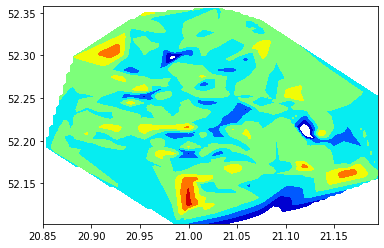

In [117]:
error_geojson, df_error=create_geojson(df_map.lon_mod,df_map.lat_mod,df_map.error,1000,-3000)

In [118]:
def plot_geojson_countour(geojson, df, title, zmin, zmax):
    trace = go.Choroplethmapbox(
                                geojson=geojson,
                                locations=df.Id,
                                z=df.value,
                                colorscale="jet",
                                zauto=False,
                                zmin=zmin,
                                zmax=zmax,

                                marker_line_width=0,

                                marker=dict(opacity=0.5),

                               )
    layout = go.Layout(
        title=title,




        height = 800,
        # top, bottom, left and right margins
        margin = dict(t = 80, b = 0, l = 0, r = 0),
        font = dict(color = 'dark grey', size = 18),

        mapbox = dict(


            center = dict(
                lat = center_coors[0],
                lon = center_coors[1]
            ),
            # default level of zoom
            zoom = 11,
            # default map style
            style = "carto-positron"
        )

    )

    figure=dict(
        data=[trace],
        layout=layout,


        )

    iplot(figure)

In [119]:
plot_geojson_countour(error_geojson, df_error,"Error geoanalysis [PLN/m2]",-3000,3000)

It seems we are missing some feature describing cultural life in a given district as geoanalysis shows that the model is underestimating the most in areas which are "popular" with vivid cultural life and overestimating in unpopular districts. To improve the results we will need additional geo data from google dealing with restaurants, museum etc. 

In [120]:
df_map.relative_error.describe()

count    314.000000
mean       2.279691
std       10.148139
min      -36.900881
25%       -2.183285
50%        1.296573
75%        6.494674
max       53.775816
Name: relative_error, dtype: float64

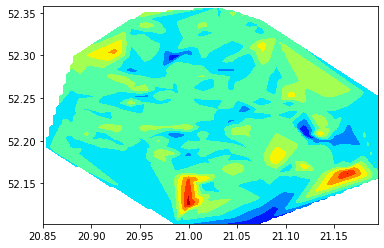

In [130]:
rel_error_geojson, df_rel_error=create_geojson(df_map.lon_mod,df_map.lat_mod,df_map.relative_error,10,-40)

In [131]:
plot_geojson_countour(rel_error_geojson, df_rel_error,"Relative Error geoanalysis [%]",-40,40)